**Upload Kaggle API Key JSON File (Run This Cell First, Then Run The Rest)**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tokobo","key":"9c6e87c462c08bb4daf6b7d23c4e3b12"}'}

**Download Files From Kaggle**

*Install Kaggle*

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*Moving Key to Correct Directory to Use Kaggle*

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

*Download Shoe Dataset*

In [ ]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

100% 47.0M/47.0M [00:03<00:00, 22.2MB/s]
100% 47.0M/47.0M [00:03<00:00, 14.4MB/s]


In [ ]:
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip && mv 'Shoe vs Sandal vs Boot Dataset' dataset

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

**Separating Images into Test, Validation, and Training Folders**

In [ ]:
from pathlib import Path
import random

random.seed(911911)

#get the file paths for each of the classes in /content/dataset
cDirectories = [ c for c in Path("/content/dataset").iterdir()]

#get all files
bootFiles = [boot for boot in Path("/content/dataset/Boot").iterdir()]
sandalFiles = [sandal for sandal in Path("/content/dataset/Sandal").iterdir()]
shoeFiles = [shoe for shoe in Path("/content/dataset/Shoe").iterdir()]

files = bootFiles + sandalFiles + shoeFiles

#randomize files
random.shuffle(files)

In [ ]:
#Create new destination folders
split = ["training", "validation", "testing"]
Path("/content/output").mkdir(parents=True, exist_ok=True)
for i in split:
  Path("/content/output/" +  i +"/Boot").mkdir(parents=True, exist_ok=True)
  Path("/content/output/" +  i +"/Sandal").mkdir(parents=True, exist_ok=True)
  Path("/content/output/" +  i +"/Shoe").mkdir(parents=True, exist_ok=True)


In [ ]:
import shutil

#Move files to new folders
trainNum = int(0.8* len(files))
testNum = int(0.1* len(files))
validNum = int(0.1* len(files))
count = 0
curFolder = split[0]
for file in files:
  if( count < trainNum ):
    curFolder = split[0]
  elif( count < trainNum + testNum ):
    curFolder = split[1]
  else:
    curFolder = split[2]
  shutil.move( str(file) , "/content/output/" + curFolder + "/" + file.parts[3])
  count = count + 1

**Imports**

In [ ]:
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers

**Preprocessing**

*Setup Image Generators for Data Augmentation and Rescaling*

In [ ]:
trainGen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255.0,
  horizontal_flip=True,
  rotation_range=20,
)

testGen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255.0
)

*Specify Directory of Images, Resize, and Specify Batch Size*

In [ ]:
trainData = trainGen.flow_from_directory(
  '/content/output/training',
  target_size=(224, 224),
  batch_size=32,
  color_mode = "rgb",
  class_mode = "sparse",
)

validData = testGen.flow_from_directory(
  '/content/output/validation',
  target_size=(224, 224),
  batch_size=32,
  color_mode = "rgb",
  class_mode = "sparse",
)

testData = testGen.flow_from_directory(
  '/content/output/testing',
  target_size=(224, 224),
  batch_size=32,
  color_mode = "rgb",
  class_mode = "sparse",
  shuffle = False
)


Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


**Model**

*ResNet*

In [ ]:
inputs = keras.Input(shape=(224,224,3))
m =  layers.Conv2D(filters = 8, kernel_size = (6,6), strides=(2,2))(inputs) 
m = layers.BatchNormalization()(m)
m = layers.Activation("relu")(m)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(m)

for i in range(3):
  m =  layers.Conv2D(filters = 8, kernel_size = (3,3), padding = "same")(x)
  m = layers.BatchNormalization()(m) 
  m = layers.Activation("relu")(m)
  m =  layers.Conv2D(filters = 8, kernel_size = (3,3), padding = "same")(m)
  m = layers.BatchNormalization()(m)
  m = layers.Activation("relu")(m)
  x = layers.Add()([x, m]) 
  x = layers.Activation("relu")(x)

x =  layers.Conv2D(filters = 16, kernel_size = (3,3), strides = (2,2))(x) 
m = layers.BatchNormalization()(x)
m = layers.Activation("relu")(m)
#
m =  layers.Conv2D(filters = 16, kernel_size = (3,3), padding = "same")(m) 
m = layers.BatchNormalization()(m)
m = layers.Activation("relu")(m)
x = layers.Add()([x, m]) 
x = layers.Activation("relu")(x)

for i in range(3):
  m =  layers.Conv2D(filters = 16, kernel_size = (3,3), padding = "same")(x) 
  m = layers.BatchNormalization()(m)
  m = layers.Activation("relu")(m)
  m =  layers.Conv2D(filters = 16, kernel_size = (3,3), padding = "same")(m)
  m = layers.BatchNormalization()(m)
  m = layers.Activation("relu")(m)
  x = layers.Add()([x, m]) 
  x = layers.Activation("relu")(x)  

x =  layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2))(x) 
m = layers.BatchNormalization()(x)
m = layers.Activation("relu")(m)
#
m =  layers.Conv2D(filters = 32, kernel_size = (3,3), padding = "same")(m) 
m = layers.BatchNormalization()(m)
m = layers.Activation("relu")(m)
x = layers.Add()([x, m]) 
x = layers.Activation("relu")(x)

for i in range(5):
  m =  layers.Conv2D(filters = 32, kernel_size = (3,3), padding = "same")(x) 
  m = layers.BatchNormalization()(m)
  m = layers.Activation("relu")(m)
  m =  layers.Conv2D(filters = 32, kernel_size = (3,3), padding = "same")(m)
  m = layers.BatchNormalization()(m)
  m = layers.Activation("relu")(m)
  x = layers.Add()([x, m]) 
  x = layers.Activation("relu")(x)  

m = layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2))(x)
m = layers.Flatten()(m)
m = layers.Dense(units = 3, activation = "softmax")(m)


model = keras.Model(inputs=inputs, outputs=m, name="JaysNet")



In [ ]:
#model = tf.keras.models.load_model("random.h5")

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(0.00001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [ ]:
training_info = model.fit(trainData, validation_data = validData, epochs = 15, verbose = 1)
model.save("JaysNet.h5")

Epoch 1/15
375/375 [==============================] - 129s 337ms/step - loss: 1.6386 - accuracy: 0.4556 - val_loss: 1.1562 - val_accuracy: 0.3913
Epoch 2/15
375/375 [==============================] - 127s 338ms/step - loss: 0.8836 - accuracy: 0.6199 - val_loss: 0.7972 - val_accuracy: 0.6467
Epoch 3/15
375/375 [==============================] - 127s 339ms/step - loss: 0.7506 - accuracy: 0.6743 - val_loss: 0.7036 - val_accuracy: 0.6953
Epoch 4/15
375/375 [==============================] - 127s 339ms/step - loss: 0.6502 - accuracy: 0.7183 - val_loss: 0.5962 - val_accuracy: 0.7320
Epoch 5/15
375/375 [==============================] - 127s 339ms/step - loss: 0.5928 - accuracy: 0.7458 - val_loss: 0.5395 - val_accuracy: 0.7613
Epoch 6/15
375/375 [==============================] - 127s 339ms/step - loss: 0.5492 - accuracy: 0.7682 - val_loss: 0.4870 - val_accuracy: 0.7853
Epoch 7/15
375/375 [==============================] - 126s 336ms/step - loss: 0.5075 - accuracy: 0.7911 - val_loss: 0.4493 -

**Visualization of Training and Validation Loss**

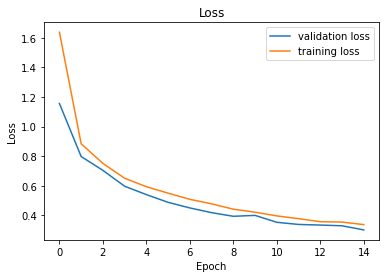

In [ ]:
plt.plot(training_info.history["val_loss"])
plt.plot(training_info.history["loss"])
plt.title("Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['validation loss', 'training loss'], loc='upper right')

**Visualization of Accuracy**

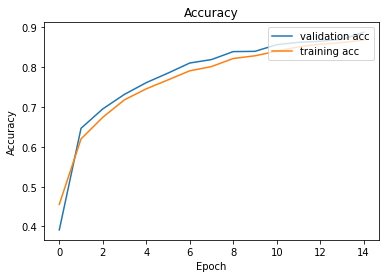

In [ ]:
plt.plot(training_info.history["val_accuracy"])
plt.plot(training_info.history["accuracy"])
plt.title("Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['validation acc', 'training acc'], loc='upper right')

**Testing**

*Evaluating the Model with Test Data*

In [ ]:
result = model.evaluate(testData)

47/47 [==============================] - 4s 83ms/step - loss: 0.2991 - accuracy: 0.8847
